# Opentron OT-2 Robot Control and Image Processing Tutorial

## Overview
This Jupyter notebook provides a comprehensive tutorial for undergraduate students to learn how to use the Opentron OT-2 liquid handling robot. The tutorial covers:

1. **Basic Opentron Concepts**: Understanding labware, pipettes, and protocol structure
2. **Robot Connectivity**: How to connect and communicate with the OT-2 robot
3. **Protocol Development**: Creating and uploading Python protocols
4. **Real-time Monitoring**: Tracking protocol execution and liquid handling operations
5. **Image Processing**: Using the built-in camera for automated image capture and analysis
6. **Data Analysis**: Processing ROI (Region of Interest) data for quantitative analysis

## What is the Opentron OT-2?
The Opentron OT-2 is an open-source liquid handling robot designed for laboratory automation. It can:
- Pipette liquids with high precision (0.5-1000 μL)
- Work with standard lab equipment (tips, plates, tubes)
- Execute complex protocols automatically
- Capture images during experiments for analysis

## Learning Objectives
By the end of this tutorial, you will understand how to:
- Set up communication with the OT-2 robot
- Define labware and pipette configurations
- Write and upload protocols to the robot
- Monitor protocol execution in real-time
- Process images captured during experiments
- Analyze experimental data using Python

---


## Part 1: Basic Opentron Concepts

### Understanding Opentron Components

Before we start programming the robot, let's understand the key concepts:

#### 1. **Labware**
Labware refers to the physical containers used in experiments:
- **96-well plates**: Standard microplates with 96 wells (8 rows × 12 columns)
- **Tip racks**: Hold pipette tips for the robot to pick up
- **Tubes and reservoirs**: For reagent storage
- **Custom labware**: Can be defined for specialized containers

#### 2. **Pipettes**
The OT-2 uses electronic pipettes that can be programmed:
- **P20 Single**: 0.5-20 μL (single channel)
- **P300 Single**: 20-300 μL (single channel)
- **P1000 Single**: 100-1000 μL (single channel)
- **P20 Multi**: 0.5-20 μL (8 channels for plate columns)
- **P300 Multi**: 20-300 μL (8 channels for plate columns)

#### 3. **Well Naming Convention**
Wells are named using row letters (A-H) and column numbers (1-12):
- `A1` = Top-left corner
- `H12` = Bottom-right corner
- Rows: A, B, C, D, E, F, G, H (top to bottom)
- Columns: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12 (left to right)

---


## Part 2: Robot Connectivity and Setup

### Understanding the HTTP API
The Opentron OT-2 robot runs a web server that accepts HTTP requests for remote control. This allows us to:
- Check robot status and health
- Upload and manage protocols
- Start and monitor protocol execution
- Capture images from the built-in camera

### Connection Parameters
- **ROBOT_IP**: The IP address of your OT-2 robot on the network
- **BASE_URL**: The complete URL for API requests (http://ROBOT_IP:31950)
- **HEADERS**: Required headers for API compatibility

### What This Code Does:
1. **Defines connection parameters** for your specific robot
2. **Tests connectivity** by making a health check request
3. **Displays robot information** including model, software versions, and capabilities

💡 **Note**: Make sure your computer and the OT-2 robot are on the same network!


In [1]:
#Setup & Check Robot Connectivity
from opentrons import protocol_api
import requests

ROBOT_IP = "192.168.50.64"  # Replace with your robot's IP address, 169.254.91.213
BASE_URL = f"http://{ROBOT_IP}:31950"
HEADERS = {"Opentrons-Version": "*"}

try:
    response = requests.get(f"{BASE_URL}/health", headers=HEADERS, timeout=5)
    if response.ok:
        print("BEARS Robot is healthy:", response.json())
    else:
        print("Failed to connect to the robot. Status code:", response.status_code)
except requests.exceptions.RequestException as e:
    print("Error connecting to the robot:", e)

BEARS Robot is healthy: {'name': 'OT2CEP20200813B01', 'robot_model': 'OT-2 Standard', 'api_version': '8.6.0', 'fw_version': 'v1.1.0-25e5cea', 'board_revision': '2.1', 'logs': ['/logs/serial.log', '/logs/api.log', '/logs/server.log', '/logs/update_server.log'], 'system_version': 'v1.19.2', 'maximum_protocol_api_version': [2, 25], 'minimum_protocol_api_version': [2, 0], 'robot_serial': 'lively-paper', 'links': {'apiLog': '/logs/api.log', 'serialLog': '/logs/serial.log', 'serverLog': '/logs/server.log', 'apiSpec': '/openapi.json', 'systemTime': '/system/time'}}


## Part 3: Protocol Upload and Execution

### How to Create a Protocol File (`protocol_modified.py`)

Before uploading, you need to create a protocol file. Here's a basic example of what `protocol_modified.py` should contain:

```python
from opentrons import protocol_api

# Protocol metadata - required for all protocols
metadata = {
    'protocolName': 'Basic Liquid Handling',
    'author': 'Student Name',
    'description': 'Simple protocol for learning OT-2 operation',
    'apiLevel': '2.13'
}

def run(protocol: protocol_api.ProtocolContext):
    """
    This function defines what the robot will do.
    It's called automatically when the protocol runs.
    """
    
    # 1. Load labware (define what equipment is on the deck)
    # Slot numbers 1-11 refer to positions on the robot deck
    plate = protocol.load_labware('corning_96_wellplate_360ul_flat', '2')
    tiprack = protocol.load_labware('opentrons_96_tiprack_300ul', '9')
    reservoir = protocol.load_labware('nest_12_reservoir_15ml', '3')
    
    # 2. Load pipette (define which pipette to use)
    # 'right' or 'left' refers to the pipette mount position
    pipette = protocol.load_instrument(
        'p300_single_gen2', 
        'right', 
        tip_racks=[tiprack]
    )
    
    # 3. Protocol steps (define the liquid handling operations)
    
    # Pick up a tip
    pipette.pick_up_tip()
    
    # Aspirate 20μL from reservoir well A1
    pipette.aspirate(20, reservoir['A1'])
    
    # Dispense 20μL to plate well A1
    pipette.dispense(20, plate['A1'])
    
    # Repeat for multiple wells
    for well in ['A2', 'A3', 'A4', 'A5', 'A6']:
        pipette.aspirate(20, reservoir['A1'])
        pipette.dispense(20, plate[well])
    
    # Drop the tip when finished
    pipette.drop_tip()
```

### Key Protocol Concepts:

#### **Labware Loading**
- `load_labware(labware_name, slot_number)`: Places labware on the robot deck
- Slot numbers 1-11 correspond to physical positions on the robot
- Common labware names: `'corning_96_wellplate_360ul_flat'`, `'opentrons_96_tiprack_300ul'`

#### **Pipette Operations**
- `aspirate(volume, location)`: Draw liquid into the pipette
- `dispense(volume, location)`: Push liquid out of the pipette
- `pick_up_tip()` / `drop_tip()`: Manage pipette tips
- Volume is specified in microliters (μL)

#### **Locations**
- Wells can be referenced by name: `plate['A1']`, `plate['H12']`
- Or by index: `plate.wells()[0]` (A1), `plate.wells()[95]` (H12)

### What This Upload Code Does:
1. **Reads the protocol file** from your local directory
2. **Uploads it to the robot** via HTTP POST request
3. **Returns a protocol ID** that identifies this specific protocol on the robot


In [6]:
import requests

protocol_file_path = "protocol_modified.py"  # Replace with your protocol file path

with open(protocol_file_path, 'rb') as file:
    files = {'files': (protocol_file_path, file)}
    response = requests.post(f"{BASE_URL}/protocols", headers=HEADERS, files=files)

if response.ok:
    protocol_id = response.json()["data"]["id"]
    print("Protocol uploaded successfully. Protocol ID:", protocol_id)
else:
    print("Failed to upload protocol. Status code:", response.status_code)
    print("Response:", response.text)

Protocol uploaded successfully. Protocol ID: c4d20c07-ead4-4fa8-a901-f3ba3353222d


## Part 4: Protocol Execution and Real-time Monitoring

### Creating and Starting a Protocol Run

Once a protocol is uploaded, we need to:
1. **Create a run**: This prepares the protocol for execution
2. **Start the run**: This begins the actual robot movements

### What This Code Does:
- **Creates a new run** using the uploaded protocol ID
- **Starts the protocol execution** by sending a "play" command
- The robot will begin following the protocol steps automatically

### Understanding Run States:
- `idle`: Robot is ready but not running
- `running`: Protocol is currently executing
- `finishing`: Protocol is completing final steps
- `succeeded`: Protocol completed successfully
- `failed`: Protocol encountered an error
- `stopped`: Protocol was manually stopped

💡 **Safety Note**: Always ensure the robot deck is properly set up with the correct labware before starting a run!


In [7]:
# Create a new run
run_response = requests.post(f"{BASE_URL}/runs", headers=HEADERS, json={"data": {"protocolId": protocol_id}})
if run_response.ok:
    run_id = run_response.json()["data"]["id"]
    print("Run created successfully. ID:", run_id)
else:
    print("Failed to create run. Status code:", run_response.status_code)
    print("Response:", run_response.text)

# Start the run
start_response = requests.post(f"{BASE_URL}/runs/{run_id}/actions", headers=HEADERS, json={"data": {"actionType": "play"}})
if start_response.ok:
    print("Run started successfully.")
else:
    print("Failed to start run. Status code:", start_response.status_code)
    print("Response:", start_response.text)

Run created successfully. ID: b9edfff1-2147-44c7-90fb-6bc177142f9d
Run started successfully.


## Part 5: Image Processing Functions

### Core Image Processing Functions

This section defines the main functions for automated image capture and analysis:

- **`capture_image()`**: Takes photos using the robot's camera
- **`crop_plate()`**: Extracts the plate region from camera images  
- **`slice_rois()`**: Divides plate into individual well regions (96 ROIs)
- **`save_rois_and_metadata()`**: Saves ROI data with experimental metadata

These functions will be used in the monitoring loop to process images captured during protocol execution.


In [38]:
# Image Processing Functions
import os
import json
import numpy as np
from PIL import Image

def capture_image(BASE_URL, HEADERS, filename="captured_image.jpg"):
    """Capture image from robot camera"""
    resp = requests.post(f"{BASE_URL}/camera/picture", headers=HEADERS)
    if resp.ok:
        with open(filename, "wb") as f:
            f.write(resp.content)
        print(f"📸 Image saved: {filename}")
        return filename
    else:
        print("❌ Failed to capture image.")
        return None

def crop_plate(image_path, out_path="cropped.jpg", crop_box=(430, 15, 610, 150)):
    """Crop plate region from full camera image"""
    image = Image.open(image_path).convert("RGB")
    cropped = image.crop(crop_box)
    cropped.save(out_path)
    print(f"🟩 Cropped image saved: {out_path}")
    pix = np.array(cropped)
    return cropped, pix

def slice_rois(pix, rows=8, cols=12, offset=((5, 6), (6, 7))):
    """Slice plate image into individual well ROIs"""
    h, w, _ = pix.shape
    dh, dw = h // rows, w // cols
    rois = []
    for r in range(rows):
        for c in range(cols):
            y1 = r*dh + offset[1][0]
            y2 = (r+1)*dh - offset[1][1]
            x1 = c*dw + offset[0][0]
            x2 = (c+1)*dw - offset[0][1]
            rois.append(pix[y1:y2, x1:x2])
    return rois

def save_rois_and_metadata(rois, base_image_id, metadata, base_dir="output"):
    """Save individual ROI images and metadata"""
    os.makedirs(base_dir, exist_ok=True)
    img_dir = os.path.join(base_dir, f"dispense_{base_image_id}")
    os.makedirs(img_dir, exist_ok=True)

    meta_path = os.path.join(img_dir, "metadata.json")
    with open(meta_path, "w") as f:
        json.dump(metadata, f, indent=2)

    for i, roi in enumerate(rois):
        img = Image.fromarray(roi.astype(np.uint8))
        roi_path = os.path.join(img_dir, f"roi_{i+1:02d}.jpg")
        img.save(roi_path)
    
    npy_path = os.path.join(img_dir, "rois.npy")
    np.save(npy_path, rois)

    print(f"🧬 Saved {len(rois)} ROIs to: {img_dir}")


## Part 6: Protocol Monitoring and Image Capture

### Real-time Protocol Monitoring

This section monitors protocol execution and captures images after the final dispense step:

- **Tracks protocol status** and liquid handling commands
- **Captures image** after protocol completion
- **Processes image** into individual well ROIs
- **Saves data** for analysis

The monitoring loop runs until the protocol finishes, then automatically processes the final image.


In [39]:
# Monitor protocol status and capture images
import requests
import time

seen_command_ids = set()
last_dispense_cmd = None

while True:
    # --- get run status ---
    run_resp = requests.get(f"{BASE_URL}/runs/{run_id}", headers=HEADERS)
    if not run_resp.ok:
        print("Failed to get run status:", run_resp.status_code)
        break

    status = run_resp.json()["data"]["status"]
    print("Current run status:", status)

    # --- get new commands ---
    cmd_resp = requests.get(f"{BASE_URL}/runs/{run_id}/commands", headers=HEADERS)
    if not cmd_resp.ok:
        print("Failed to get commands:", cmd_resp.status_code)
        break

    for cmd in cmd_resp.json()["data"]:
        cid = cmd["id"]
        if cid in seen_command_ids:
            continue
        seen_command_ids.add(cid)

        ctype = cmd.get("commandType", "")
        params = cmd.get("params", {})
        volume = params.get("volume")
        location = params.get("labware") or params.get("well")

        if ctype in ("aspirate", "dispense") and volume is not None:
            print(f"🔄 {ctype.capitalize()}  Volume: {volume} µL  |  Location: {location}")

            if ctype == "dispense":
                last_dispense_cmd = {
                    "id": cid,
                    "volume": volume,
                    "location": location
                }

    # --- exit when run finishes ---
    if status in ("succeeded", "failed", "stopped"):
        print(f"✅ Protocol {status}.")
        break

    time.sleep(5)

# --- process only the last dispense image ---
if last_dispense_cmd:
    cid = last_dispense_cmd["id"]
    volume = last_dispense_cmd["volume"]
    location = last_dispense_cmd["location"]
    print(f"\n📌 Capturing only the last dispense (ID: {cid})")

    raw_name = f"dispense_image.jpg"
    img_path = capture_image(BASE_URL, HEADERS, filename=raw_name)

    if img_path:
        # Proceed with image correction + cropping
        # First, process the captured image
        cropped_image, pix = crop_plate(img_path, out_path="cropped_dispense.jpg")
        
        # Now extract ROIs from the processed image
        rois = slice_rois(pix)

        save_rois_and_metadata(
            rois=rois,
            base_image_id=cid,
            metadata={"volume": volume, "location": location}
        )

time.sleep (5)

Current run status: succeeded
🔄 Aspirate  Volume: 20.0 µL  |  Location: None
🔄 Dispense  Volume: 20.0 µL  |  Location: None
🔄 Aspirate  Volume: 20.0 µL  |  Location: None
🔄 Dispense  Volume: 20.0 µL  |  Location: None
🔄 Aspirate  Volume: 20.0 µL  |  Location: None
🔄 Dispense  Volume: 20.0 µL  |  Location: None
🔄 Aspirate  Volume: 20.0 µL  |  Location: None
🔄 Dispense  Volume: 20.0 µL  |  Location: None
🔄 Aspirate  Volume: 20.0 µL  |  Location: None
🔄 Dispense  Volume: 20.0 µL  |  Location: None
✅ Protocol succeeded.

📌 Capturing only the last dispense (ID: command.DISPENSE-4)
📸 Image saved: dispense_image.jpg
🟩 Cropped image saved: cropped_dispense.jpg
🧬 Saved 96 ROIs to: output\dispense_command.DISPENSE-4


## Part 7: Reference Image Capture

### Taking a Reference Image

Capture a reference image to verify camera setup and establish baseline conditions.


In [40]:
# Capture reference image
image_response = requests.post(f"{BASE_URL}/camera/picture", headers=HEADERS)
if image_response.ok:
    with open("captured_image.jpg", "wb") as f:
        f.write(image_response.content)
    print("Image captured and saved as 'captured_image.jpg'.")
else:
    print("Failed to capture image. Status code:", image_response.status_code)
    print("Response:", image_response.text)

Image captured and saved as 'captured_image.jpg'.


## Part 8: Image Display and Verification

### Display Reference Image

Display the captured reference image to verify camera positioning and image quality before processing.


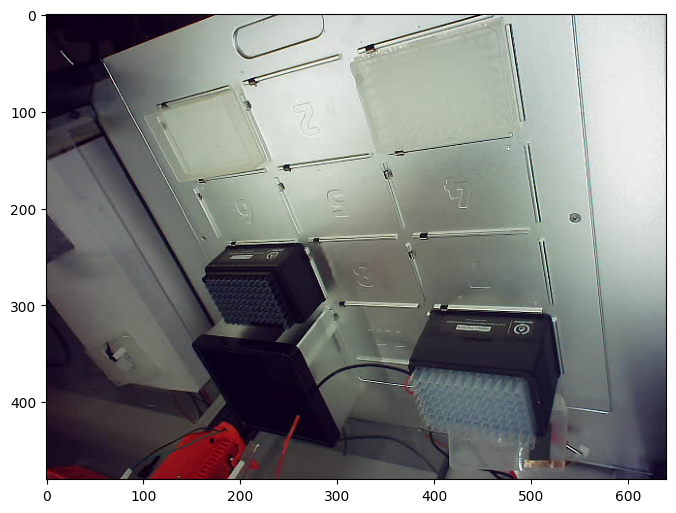

In [41]:
pic_folder = '.'  # Current folder (relative path)
# Read all the files from a specified directory
images_list=[]
# for (dirpath, dirnames, filenames) in os.walk(pic_folder):
#     for filename in filenames:
#         if filename!='.DS_Store':
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

for img in os.listdir(pic_folder):
    if img.endswith("captured_image.jpg"):
        image_path = os.path.join(pic_folder, img)
        image = Image.open(image_path, 'r')
        im = Image.fromarray(np.array(image, dtype=np.uint8), 'RGB')
        # Proceed with image processing

        # Create figure and axes
        fig,ax = plt.subplots(1,figsize=(8,8))
        # Display the image
        ax.imshow(im)
        plt.show()            
#
# test picture for adjusting the cropping box
# should try mutiple ones for the optimium cropping box options

## Part 9: Perspective Correction Functions

### Image Transformation

Define functions to correct perspective distortion and transform the image for proper analysis.


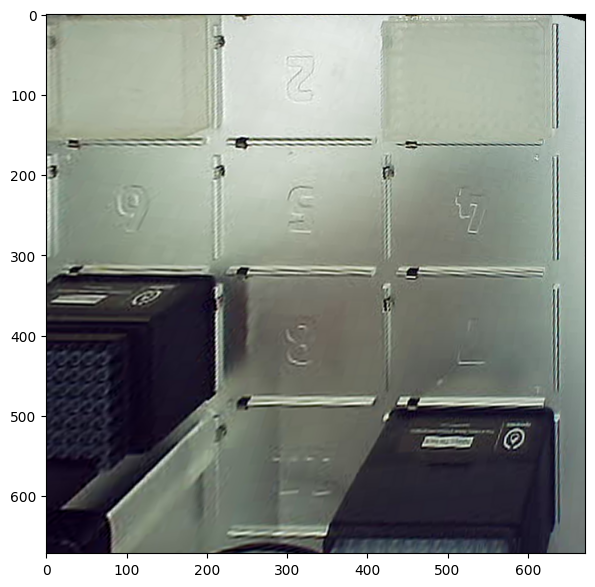

In [42]:
import numpy

def find_coeffs(pa, pb):
    matrix = []
    for p1, p2 in zip(pa, pb):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = numpy.matrix(matrix, dtype=float)  # <-- fixed here
    B = numpy.array(pb).reshape(8)

    res = numpy.dot(numpy.linalg.inv(A.T * A) * A.T, B)
    return numpy.array(res).reshape(8)

img = image
width, height = img.size
m = -0.1
n = 0.1
xshift = abs(m) * width
yshift = abs(n) * height
new_width = width + int(round(xshift))
new_height = height +int(round(yshift))
final_coeffs = [(110, 100), (480, 0), (525, 305), (209, 295)]  # Start with current
final_crop = (430, 15, 610, 150) 
coeffs = find_coeffs(
        [(0, 0), (640, 0), (640, 480), (0, 480)],
        final_coeffs)

img_corr = img.transform((int(width*1.05), int(height*1.4)), Image.PERSPECTIVE, coeffs, Image.BICUBIC)

# Create figure and axes
fig,ax = plt.subplots(1,figsize=(7,7))
# Display the image
ax.imshow(img_corr)
plt.show()

## Part 10: Image Correction and Cropping

### Apply Perspective Correction

Apply the transformation to correct perspective distortion and crop the plate region for analysis.


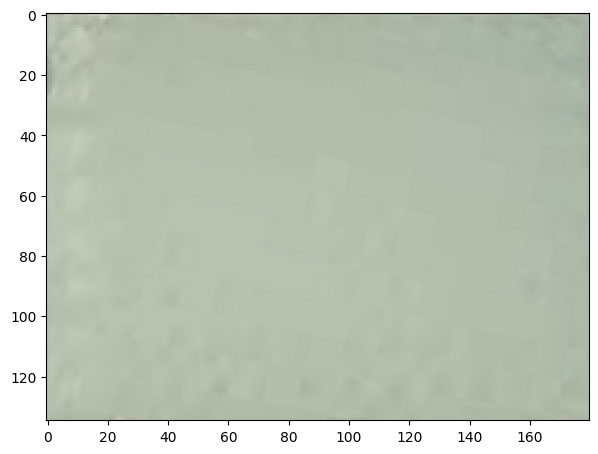

In [43]:
crop_box= final_crop 
image_cropped = img_corr.crop(box=crop_box) #box=(left, upper, right, lower)

# Create figure and axes
fig,ax = plt.subplots(1,figsize=(7,7))
# Display the image
ax.imshow(image_cropped)
plt.show()

## Part 11: ROI Extraction and Analysis

### Extract Individual Well Regions

Define functions to slice the plate image into individual well regions and visualize the results with bounding boxes.


In [44]:
import matplotlib.patches as patches

def get_image_array(image, crop_box):
    """Get a numpy array of an image so that one can access values[x][y]."""
    image = image.crop(box=crop_box) #box=(left, upper, right, lower)
    [width,height] = image.size
    pixel_values = list(image.getdata())
    if image.mode == 'RGB':
        channels = 3
    elif image.mode == 'L':
        channels = 1
    else:
        print("Unknown mode: %s" % image.mode)
        return None
    pixel_values = np.array(pixel_values).reshape((height, width, channels))
    return (width,height,pixel_values)

def image_slicing(image_array, col_num,row_num, offset_array):
    """slice the ROIs from an image of an array of samples/colorcard"""
    row_h = int(np.round(image_array.shape[0]/row_num))
    col_w = int(np.round(image_array.shape[1]/col_num))
    
    fig,ax = plt.subplots(1,figsize=(8,8))
    images = []
    imagecol = []
    for y in np.arange(row_num):
        imagerow = []
        for x in np.arange(col_num):
            # slicing indices for each color square
            y1 = row_h*y+offset_array[1][0]
            y2 = row_h*(y+1)-offset_array[1][1]
            x1 = col_w*x+offset_array[0][0]
            x2 = col_w*(x+1)-offset_array[0][1]
            image = image_array[y1:y2,x1:x2]
            imagerow.append(image)#append every images in a row into a row list
            images.append(image)#append every images into a list
            # Add the rectangular patch to the Axes
            # Create a Rectangle patch
            lw=1 # Line width
            ec='r' # edge color
            fc='none' # face color
            rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,
                                      linewidth=lw,edgecolor=ec,facecolor=fc)
            ax.add_patch(rect)
    
        imagecol.append(np.concatenate(imagerow, axis=1))
    image_reconstr = np.array(np.concatenate(imagecol, axis=0), dtype=np.uint8)

    return [fig, ax, image_reconstr, images]


## Part 12: Data Visualization - Bar Chart Analysis

### Creating Comprehensive Visualizations

This section creates a bar chart showing RGB values for all wells:

#### **Visualization Features:**
- **Separate bars** for Red, Green, and Blue channels
- **Color-coded bars** (red, green, blue) for easy identification
- **All 96 wells displayed** in a single comprehensive chart
- **Rotated labels** for better readability

#### **What This Chart Reveals:**

1. **Channel Differences**: 
   - Some wells may have higher red vs. green vs. blue content
   - Color balance indicates the type of colorimetric reaction

2. **Well-to-Well Variation**:
   - Consistent patterns across similar treatments
   - Outliers that may need investigation
   - Gradients that indicate dose-response relationships

3. **Experimental Success**:
   - Clear differences between treatment groups
   - Appropriate controls (empty wells, positive controls)
   - Expected color changes based on the assay

#### **Interpreting the Results:**

- **Flat profiles**: All RGB values similar → minimal color change
- **Dominant channels**: One color much higher → specific color development
- **Well clusters**: Groups of wells with similar profiles → consistent treatments
- **Progressive changes**: Gradual changes across wells → dose-response curves

### Using This Data for Research:

This visualization helps you:
- **Identify successful experiments** with clear color changes
- **Spot technical problems** like uneven dispensing or contamination
- **Select optimal conditions** for follow-up experiments
- **Prepare data for publication** in scientific reports

💡 **Pro Tip**: Save high-resolution versions of these plots for inclusion in lab reports and presentations!


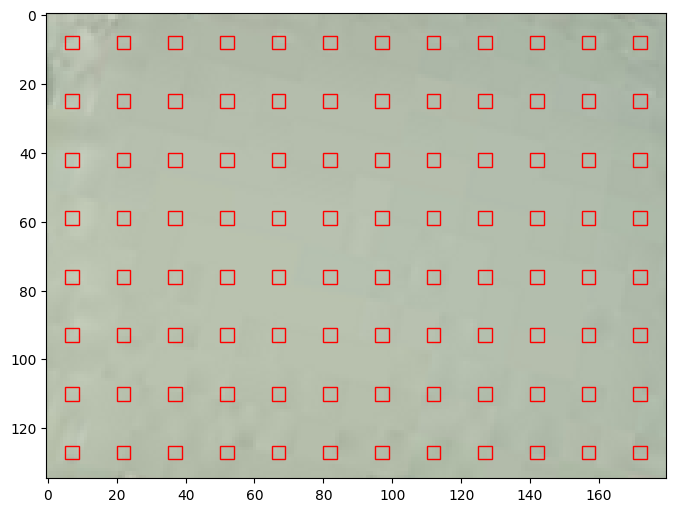

In [45]:
w, h, image_array = get_image_array(img_corr, crop_box)
              
# Row, Columns Settings and Offset pixels for each sample (TO BE CHANGED)
row_num=8
col_num=12
offset_array= [[5,6],[6,7]]#[[x_left,x_right],[y_upper,y_lower]]
########%%%%%%%%%%%%%%%%%%%%%%%%###############
[fig_ROI, ax_ROI, reconstr_ROI, image_ROI]= image_slicing(
        image_array, col_num, row_num, offset_array)
ax_ROI.imshow(Image.fromarray(np.array(image_array, dtype=np.uint8), 'RGB'))
fig_ROI.savefig(os.path.join(pic_folder, "reconstructed_with_boxes.jpg"))
plt.show()

from PIL import Image


## Part 13: Reference ROI Analysis

### Display Empty Well Reference

Display and analyze a reference ROI (typically an empty well) to establish baseline RGB values for comparison.


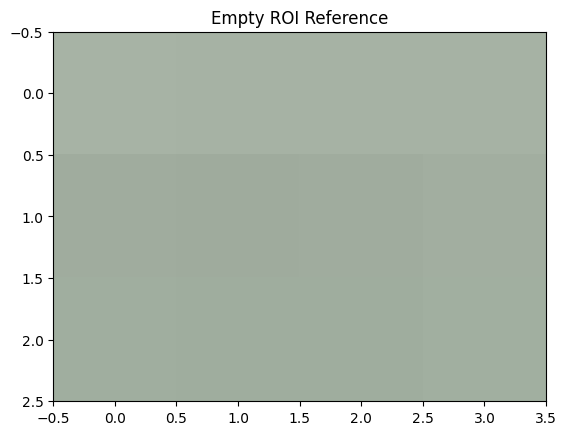

In [ ]:
#Visulise empty_roi

# # Use this to load a previous rois.npy file, if rois have not been defined
# img_dir = "./output/dispense_command.DISPENSE-4"  # change to your actual folder
# npy_path = os.path.join(img_dir, "rois.npy")
# rois = np.load(npy_path, allow_pickle=True)  # allow_pickle=True if you saved a list

empty_roi = rois[1]  # A1, assuming it's always empty
empty_rgb = np.mean(empty_roi, axis=(1, 2))

plt.imshow(empty_roi)
plt.title("Empty ROI Reference")
plt.show()


## Part 14: RGB Analysis

### Calculate Average RGB Values

Calculate average RGB values for the processed image and individual ROI regions for quantitative analysis.


In [32]:
from PIL import Image
import numpy as np

# Load image
image = Image.open("dispense_image.jpg").convert("RGB")

# Convert to NumPy array
np_image = np.array(image)

# Average RGB across all pixels
avg_rgb = np.mean(np_image, axis=(0, 1))  # shape: (3,)
print(f"Average RGB: {avg_rgb}")


Average RGB: [119.84338216 121.37993815 120.1319043 ]


## Part 15: Data Visualization

### Create RGB Bar Charts

Generate comprehensive bar charts showing RGB values for all wells to visualize experimental results.


In [33]:
for i, roi in enumerate(rois):  # each `roi` is a PIL Image
    rgb_avg = np.mean(np.array(roi), axis=(0, 1))
    print(f"ROI {i+1} Average RGB: {rgb_avg}")


ROI 1 Average RGB: [177.58333333 185.58333333 170.58333333]
ROI 2 Average RGB: [162.16666667 174.83333333 160.5       ]
ROI 3 Average RGB: [167.91666667 174.58333333 163.91666667]
ROI 4 Average RGB: [124.25       131.         135.41666667]
ROI 5 Average RGB: [196.58333333 208.33333333 204.75      ]
ROI 6 Average RGB: [201.33333333 211.33333333 207.83333333]
ROI 7 Average RGB: [206.5 215.5 212.5]
ROI 8 Average RGB: [220.41666667 227.58333333 225.16666667]
ROI 9 Average RGB: [217.83333333 226.16666667 223.33333333]
ROI 10 Average RGB: [227. 231. 230.]
ROI 11 Average RGB: [229.33333333 233.33333333 232.33333333]
ROI 12 Average RGB: [228.75 232.75 231.75]
ROI 13 Average RGB: [169. 180. 164.]
ROI 14 Average RGB: [169. 181. 167.]
ROI 15 Average RGB: [173.66666667 180.5        171.75      ]
ROI 16 Average RGB: [145.33333333 145.75       145.58333333]
ROI 17 Average RGB: [193.66666667 203.83333333 202.08333333]
ROI 18 Average RGB: [198.25 209.25 205.25]
ROI 19 Average RGB: [204.25 214.75 211. 

ROI 1 Average RGB: [177.58333333 185.58333333 170.58333333]
ROI 2 Average RGB: [162.16666667 174.83333333 160.5       ]
ROI 3 Average RGB: [167.91666667 174.58333333 163.91666667]
ROI 4 Average RGB: [124.25       131.         135.41666667]
ROI 5 Average RGB: [196.58333333 208.33333333 204.75      ]
ROI 6 Average RGB: [201.33333333 211.33333333 207.83333333]
ROI 7 Average RGB: [206.5 215.5 212.5]
ROI 8 Average RGB: [220.41666667 227.58333333 225.16666667]
ROI 9 Average RGB: [217.83333333 226.16666667 223.33333333]
ROI 10 Average RGB: [227. 231. 230.]
ROI 11 Average RGB: [229.33333333 233.33333333 232.33333333]
ROI 12 Average RGB: [228.75 232.75 231.75]
ROI 13 Average RGB: [169. 180. 164.]
ROI 14 Average RGB: [169. 181. 167.]
ROI 15 Average RGB: [173.66666667 180.5        171.75      ]
ROI 16 Average RGB: [145.33333333 145.75       145.58333333]
ROI 17 Average RGB: [193.66666667 203.83333333 202.08333333]
ROI 18 Average RGB: [198.25 209.25 205.25]
ROI 19 Average RGB: [204.25 214.75 211. 

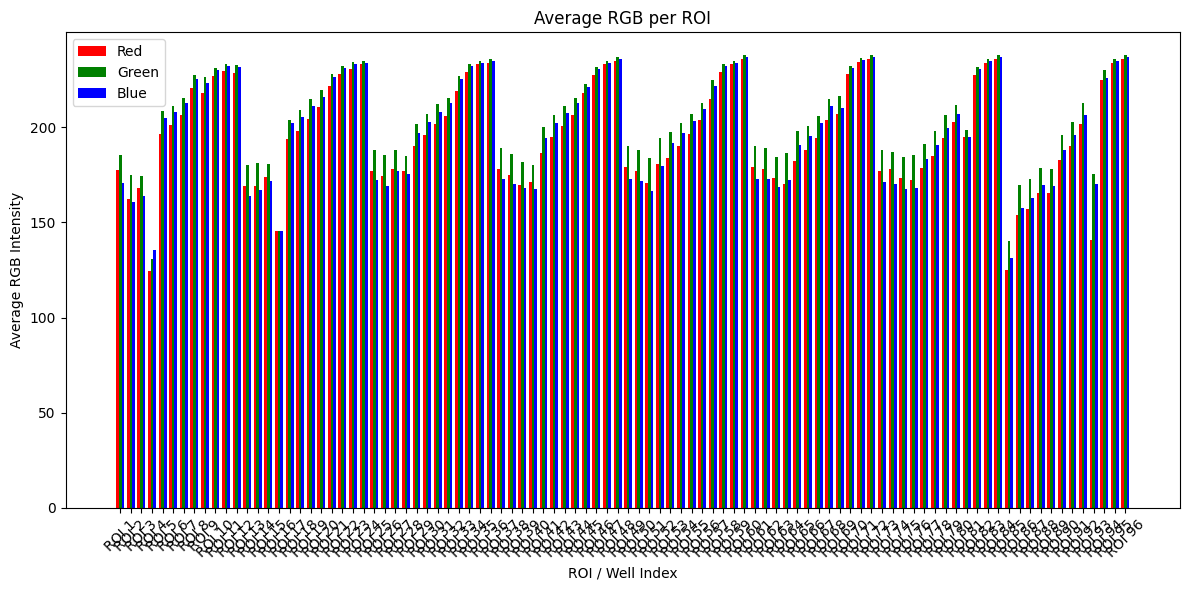

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Collect average RGBs for each ROI
avg_rgbs = []
for i, roi in enumerate(rois):  # each `roi` is a PIL Image
    rgb_avg = np.mean(np.array(roi), axis=(0, 1))
    avg_rgbs.append(rgb_avg)
    print(f"ROI {i+1} Average RGB: {rgb_avg}")

# Convert to NumPy array
avg_rgbs = np.array(avg_rgbs)  # shape: (num_rois, 3)
r_vals = avg_rgbs[:, 0]
g_vals = avg_rgbs[:, 1]
b_vals = avg_rgbs[:, 2]

# Bar plot settings to see each ROI's RGB values 
x = np.arange(len(rois))  # Index for each ROI
width = 0.25  # Width of each bar

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width, r_vals, width, color='red', label='Red')
ax.bar(x, g_vals, width, color='green', label='Green')
ax.bar(x + width, b_vals, width, color='blue', label='Blue')

# Formatting
ax.set_xlabel("ROI / Well Index")
ax.set_ylabel("Average RGB Intensity")
ax.set_title("Average RGB per ROI")
ax.set_xticks(x)
ax.set_xticklabels([f"ROI {i+1}" for i in x], rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


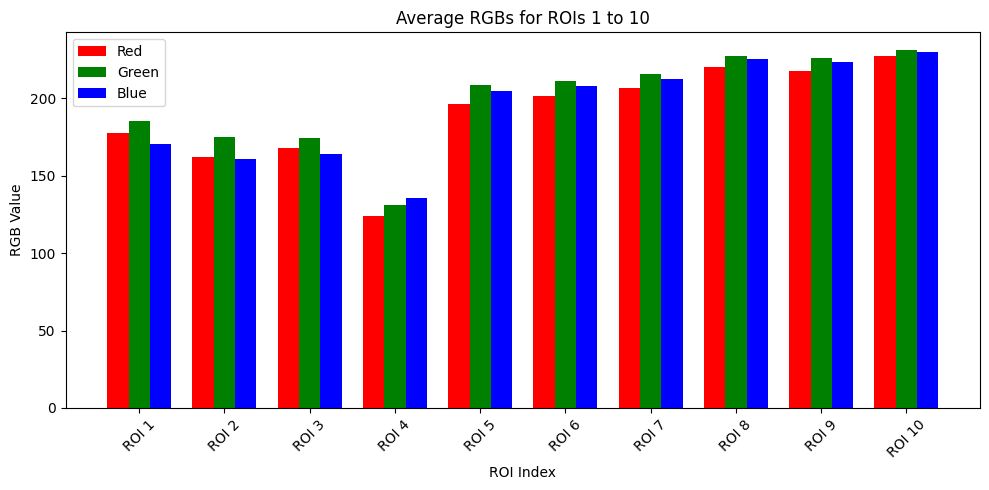

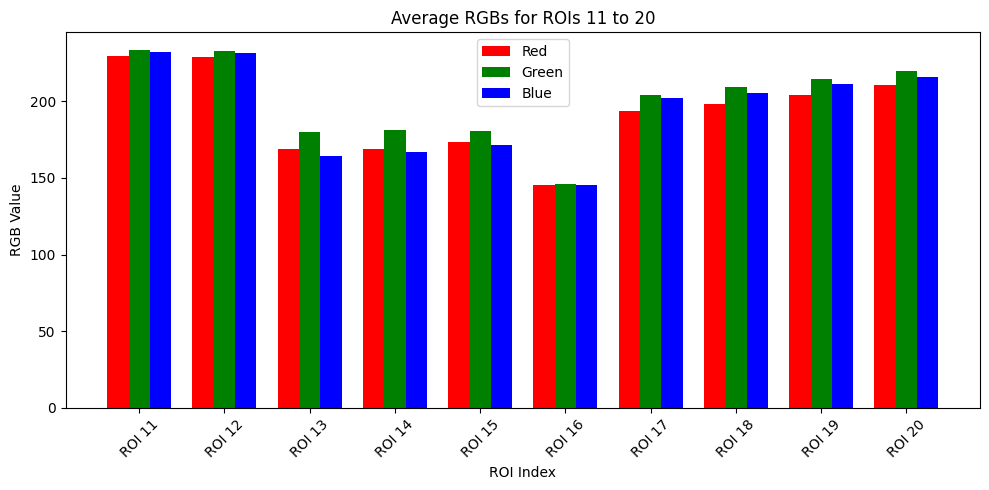

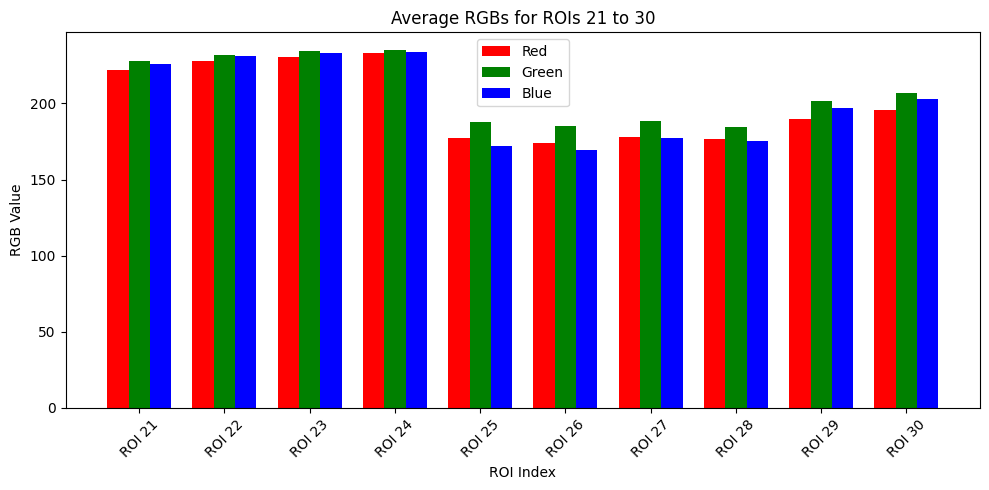

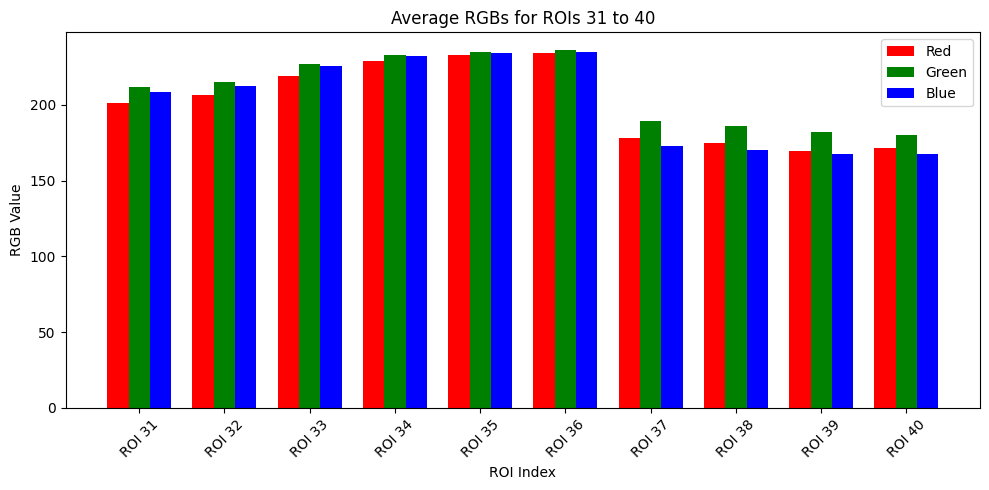

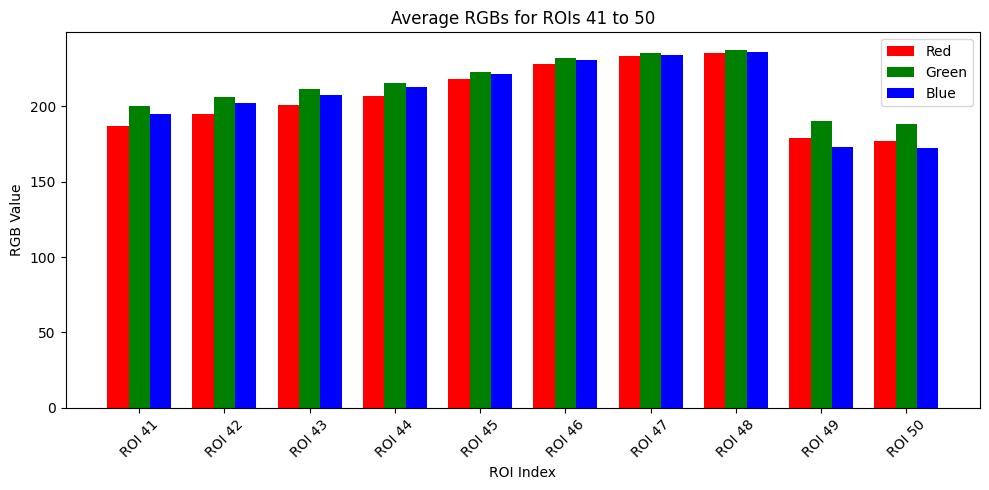

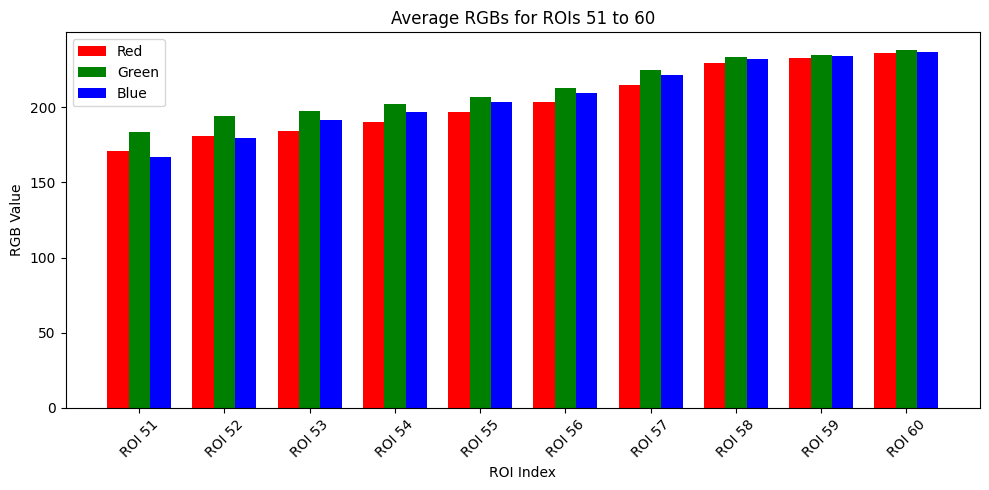

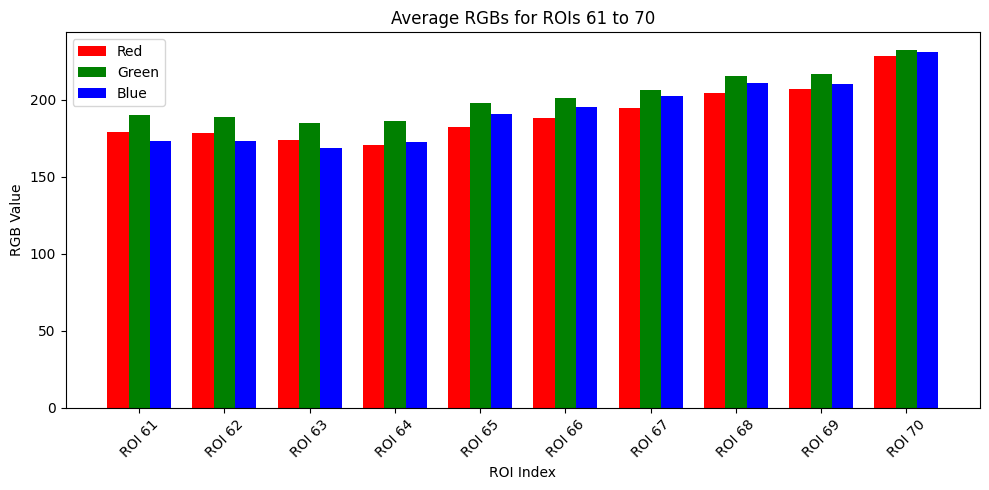

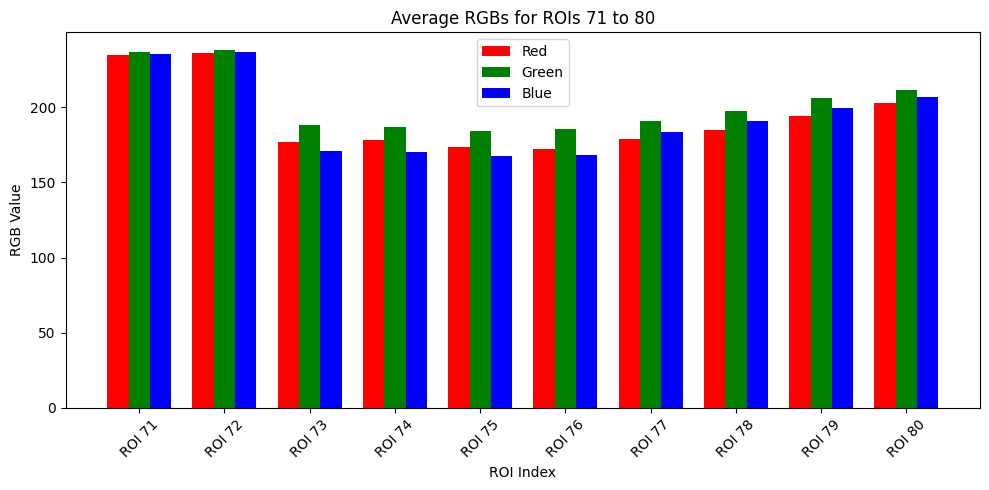

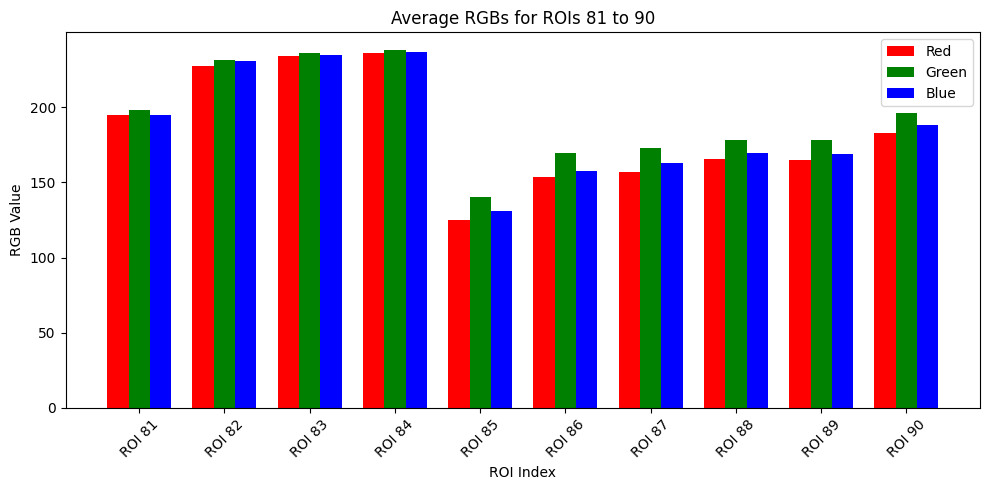

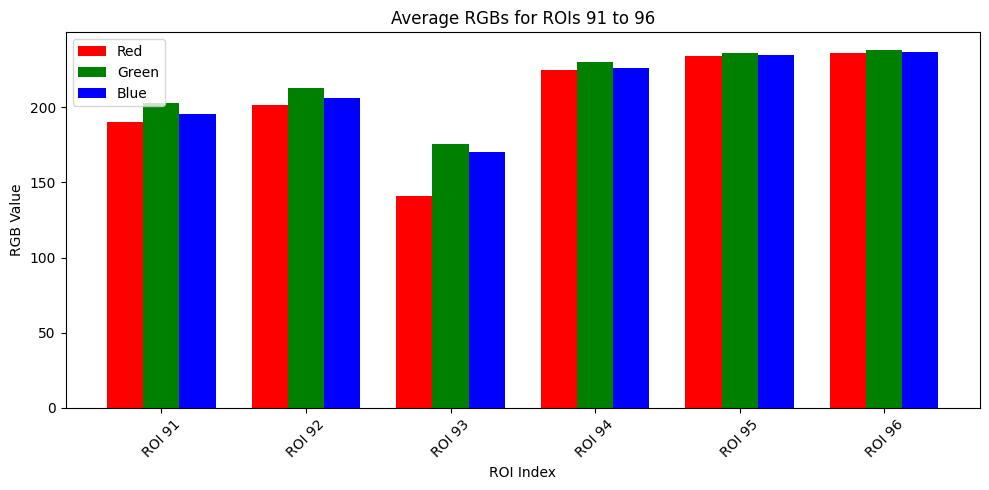

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# --- Step 1: Compute average RGBs ---
avg_rgbs = []
for i, roi in enumerate(rois):  # assuming each `roi` is a PIL Image
    rgb_avg = np.mean(np.array(roi), axis=(0, 1))
    avg_rgbs.append(rgb_avg)

avg_rgbs = np.array(avg_rgbs)  # shape: (num_rois, 3)

# --- Step 2: Plot in chunks of 10 ROIs ---
def plot_rgb_chunks(avg_rgbs, chunk_size=10):
    num_chunks = int(np.ceil(len(avg_rgbs) / chunk_size))

    for c in range(num_chunks):
        start = c * chunk_size
        end = min((c + 1) * chunk_size, len(avg_rgbs))
        chunk = avg_rgbs[start:end]

        r_vals = chunk[:, 0]
        g_vals = chunk[:, 1]
        b_vals = chunk[:, 2]
        x = np.arange(len(chunk))
        width = 0.25

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.bar(x - width, r_vals, width, color='red', label='Red')
        ax.bar(x, g_vals, width, color='green', label='Green')
        ax.bar(x + width, b_vals, width, color='blue', label='Blue')

        ax.set_title(f"Average RGBs for ROIs {start + 1} to {end}")
        ax.set_xlabel("ROI Index")
        ax.set_ylabel("RGB Value")
        ax.set_xticks(x)
        ax.set_xticklabels([f"ROI {i+1}" for i in range(start, end)], rotation=45)
        ax.legend()
        plt.tight_layout()
        plt.show()

# --- Step 3: Call the function ---
plot_rgb_chunks(avg_rgbs, chunk_size=10)
